## Target: using python and numpy implement a neural network framework.

Node:
+ forward: Function, how to calculate the inputs
+ backwards: Function, how to get the gradients when backpropogation
+ gradients: Mapper, the gradient map the this node of its inputs node
+ inputs: List, the input nodes of this node
+ outputs: List, the output node of this node

In [177]:
class Node:
    """
    Each node in neural networks will have these attributes and methods
    """
    def __init__(self, inputs=[]):
        """
        if the node is the operator of "ax + b", the inputs will be x node , and the outputs 
        of this is its successors. 
        
        and the value is *ax + b*
        """
        self.inputs = inputs # input_list <- C, Java <- 匈牙利命名法 -> Python 特别不建议
       # self.outputs = outputs # output_list 
        self.value = None 
        self.outputs = []
        self.gradients = {}
        
        for node in self.inputs:
            node.outputs.append(self) # build a connection relationship
    
    def forward(self):
        """Forward propogation
        
        compute the output value based on input nodes and store the value 
        into *self.value*
        """
        raise NotImplemented
    
    def backward(self):
        """ Back propogation
        
        compute the gradient of each input node and store the value 
        into "self.gredients"
        """
        raise NotImplemented

In [178]:
class Input(Node):
    def __init__(self, name=''):
        Node.__init__(self, inputs=[])
        self.name= name
    
    def forward(self, value=None):
        if value is not None:
            self.value = value
        
    def backward(self):
        self.gradients = {}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost
    
    def __repr__(self):
        return 'Input Node: {}'.format(self.name)

In [179]:
import numpy as np

In [180]:
X = np.array([1, 2, 3])

In [181]:
W = np.array([[1, 2], [2, 4], [3, 5]])

In [182]:
X.shape

(3,)

In [183]:
W.shape

(3, 2)

In [184]:
B = np.array([1, 3])

In [185]:
B.shape

(2,)

In [186]:
np.dot(X, W)

array([14, 25])

In [187]:
np.dot(X, W) + B

array([15, 28])

In [188]:
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias
        Node.__init__(self, inputs=[nodes, weights, bias])
    
    def forward(self): 
        """compute the wx + b using numpy"""
        self.value = np.dot(self.x_node.value, self.w_node.value) + self.b_node.value
        
    
    def backward(self):
        
        for node in self.outputs:
            #gradient_of_loss_of_this_output_node = node.gradient[self]
            grad_cost = node.gradients[self]
            
            self.gradients[self.w_node] = np.dot(self.x_node.value.T, grad_cost)
            self.gradients[self.b_node] = np.sum(grad_cost * 1, axis=0, keepdims=False)
            self.gradients[self.x_node] = np.dot(grad_cost, self.w_node.value.T)

In [189]:
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
        self.x_node = node
    
    def _sigmoid(self, x):
        return 1. / (1 + np.exp(-1 * x))
    
    def forward(self):
        self.value = self._sigmoid(self.x_node.value)
    
    def backward(self):
        y = self.value
        
        self.partial = y * (1 - y)
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            
            self.gradients[self.x_node] = grad_cost * self.partial        

In [190]:
W1 = np.array([[1, 1], [1, 2], [1, 3]])
W2 = np.array([[1, 1], [0, 2], [1, 4]])

In [191]:
(W1.reshape(-1, 1) - W2.reshape(-1, 1)) ** 2

array([[0],
       [0],
       [1],
       [0],
       [0],
       [1]])

In [192]:
class MSE(Node):
    def __init__(self, y_true, y_hat):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        Node.__init__(self, inputs=[y_true, y_hat])
    
    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1, 1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1, 1)
        
        self.diff = y_true_flatten - y_hat_flatten
        
        self.value = np.mean(self.diff**2)
        
    def backward(self):
        n = self.y_hat_node.value.shape[0]
        
        self.gradients[self.y_true_node] = (2 / n) * self.diff
        self.gradients[self.y_hat_node] =  (-2 / n) * self.diff

In [193]:
def training_one_batch(topological_sorted_graph):
    # graph 是经过拓扑排序之后的 一个list
    for node in topological_sorted_graph:
        node.forward()
        
    for node in topological_sorted_graph[::-1]:
        node.backward()

In [194]:
def topological_sort(data_with_value):
    feed_dict = data_with_value 
    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

In [195]:
def sgd_update(trainable_nodes, learning_rate = 1e-2):
    for t in trainable_nodes:
        t.value += -1 * learning_rate * t.gradients[t]

In [196]:
from sklearn.datasets import load_boston

In [197]:
data = load_boston()

In [198]:
X_ = data['data']
X    # 上面定义的

array([1, 2, 3])

In [199]:
y_ = data['target']

In [200]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [201]:
y_[0]

24.0

In [202]:
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

In [203]:
n_features = X_.shape[1]

In [204]:
n_hidden = 10

In [205]:
n_hidden_2 = 10

In [206]:
X.shape

(3,)

In [207]:
W1_, b1_ = np.random.randn(n_features, n_hidden), np.zeros(n_hidden)

In [208]:
W2_, b2_ = np.random.randn(n_hidden, 1), np.zeros(1)

## Build a graph connection

### 1st. Build Nodes in this graph

In [209]:
X, y = Input(name='X'), Input(name='y')    # tensorflow -> placeholder

W1, b1 = Input(name='W1'), Input(name='b1')
W2, b2 = Input(name='W2'), Input(name='b2')

### 2nd build connection relationship

In [210]:
linear_output = Linear(X, W1, b1)
sigmoid_output = Sigmoid(linear_output)
yhat = Linear(sigmoid_output, W2, b2)
loss = MSE(y, yhat)

In [211]:
input_node_with_value = {  # -> feed_dict 
    X: X_, 
    y: y_, 
    W1: W1_, 
    W2: W2_, 
    b1: b1_, 
    b2: b2_
}

In [212]:
graph = topological_sort(input_node_with_value)

In [213]:
graph

[Input Node: W1,
 Input Node: y,
 Input Node: b2,
 Input Node: W2,
 Input Node: b1,
 Input Node: X,

In [214]:
from sklearn.utils import resample

In [215]:
np.random.choice(range(100), size=10, replace=True)

array([29, 52, 12, 18, 88, 16, 19,  5, 21, 63])

In [216]:
def run(dictionary):
    return topological_sort(dictionary)

In [217]:
losses = []
epochs = 5000

batch_size = 64

steps_per_epoch = X_.shape[0] // batch_size


for i in range(epochs):
    loss = 0
    
    for batch in range(steps_per_epoch):
        X_batch, y_batch = resample(X_, y_, n_samples = batch_size)
        X.value = X_batch
        y.value = y_batch
        
        training_one_batch(graph)
        
        learning_rate = 1e-3
        
        sgd_update(trainable_nodes=[W1, W2, b1, b2], learning_rate = learning_rate)
        
        loss += graph[-1].value
        
    if i % 100 == 0:
        print('Epoch: {}, loss = {:.3f}'.format(i+1, loss/steps_per_epoch))
        losses.append(loss)        

Epoch: 1, loss = 565.920
Epoch: 101, loss = 34.659
Epoch: 201, loss = 30.108
Epoch: 301, loss = 19.433
Epoch: 401, loss = 17.523
Epoch: 501, loss = 15.489
Epoch: 601, loss = 11.957
Epoch: 701, loss = 9.976
Epoch: 801, loss = 11.313
Epoch: 901, loss = 13.439
Epoch: 1001, loss = 12.500
Epoch: 1101, loss = 12.883
Epoch: 1201, loss = 10.199
Epoch: 1301, loss = 12.534
Epoch: 1401, loss = 9.245
Epoch: 1501, loss = 11.180
Epoch: 1601, loss = 8.778
Epoch: 1701, loss = 9.437
Epoch: 1801, loss = 11.259
Epoch: 1901, loss = 8.583
Epoch: 2001, loss = 10.749
Epoch: 2101, loss = 8.993
Epoch: 2201, loss = 11.747
Epoch: 2301, loss = 9.941
Epoch: 2401, loss = 7.674
Epoch: 2501, loss = 9.360
Epoch: 2601, loss = 10.564
Epoch: 2701, loss = 9.339
Epoch: 2801, loss = 7.452
Epoch: 2901, loss = 7.880
Epoch: 3001, loss = 6.248
Epoch: 3101, loss = 9.246
Epoch: 3201, loss = 7.399
Epoch: 3301, loss = 6.913
Epoch: 3401, loss = 9.488
Epoch: 3501, loss = 7.642
Epoch: 3601, loss = 7.761
Epoch: 3701, loss = 6.394
Epoch

In [218]:
import matplotlib.pyplot as plt

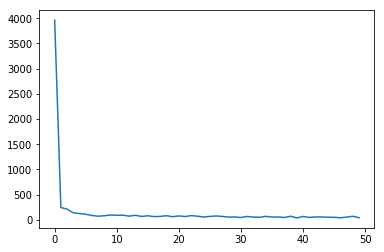

In [219]:
plt.plot(losses)

In [220]:
W1.value

array([[ 0.24566944,  0.06588901, -2.09861364, -0.20170475,  0.08473787,
        -0.07584555, -1.3144071 ,  0.55269107, -1.88116877,  0.40043592],
       [-0.40582129,  0.47978895, -0.48739602,  0.66029005, -0.1683364 ,
         0.99473484, -1.6102824 , -0.00956492, -0.65795686,  2.11299043],
       [ 0.27520294, -1.08269976,  0.36072561, -0.48729598,  0.25210396,
        -1.2963591 ,  1.12041483,  1.28363158, -0.88001027,  1.46299218],
       [ 1.05292054,  0.29055881,  2.225596  ,  0.18345418, -0.89744813,
        -0.19448887, -0.43251751, -0.14451473,  2.11112405, -0.33613171],
       [-0.49056689, -1.65004363,  0.30665326,  0.51480934,  0.8119536 ,
        -1.06684996, -1.96485892, -0.23890294,  1.22306029,  1.6872514 ],
       [ 2.45421751, -1.52637465, -0.9462694 ,  1.1076324 ,  1.96355309,
        -0.7712349 ,  0.83113279,  3.33074482,  1.01780987,  1.84975766],
       [ 0.52469627, -0.53803371,  0.26607645, -0.93839163, -0.06075629,
         1.7213122 , -1.73764191, -0.04100714

In [221]:
W2.value

array([[ 7.78456099],
       [ 7.9787582 ],
       [ 3.26695365],
       [10.11030089],
       [ 6.16677033],
       [ 7.59225567],
       [ 5.48365675],
       [ 1.87385363],
       [ 2.66217874],
       [ 3.08737487]])

In [226]:
X_[1]

array([-0.41733926, -0.48772236, -0.59338101, -0.27259857, -0.74026221,
        0.19427445,  0.36716642,  0.55715988, -0.8678825 , -0.98732948,
       -0.30309415,  0.44105193, -0.49243937])

In [227]:
x1 = Input()

In [228]:
x1.value = X_[1]

In [229]:
y_of_x1 =  Linear(Sigmoid(Linear(x1, W1, b1)), W2, b2)

In [232]:
y_of_x1

In [231]:
W1.value.shape

(13, 10)

In [233]:
def _sigmoid(x):
        return 1. / (1 + np.exp(-1 * x))

In [234]:
np.dot(_sigmoid(np.dot(X_[1], W1.value) + b1.value), W2.value) + b2.value

array([21.80955614])

In [235]:
y_[1]

21.6

In [236]:
y_of_x1